In [49]:
import os
import sys
import tarfile
import numpy as np
import igraph as ig
import pandas as pd
import matplotlib.pyplot as plt
from plot_auxiliary import *

from mpl_settings_v3 import *

from auxiliary import get_base_network_name, supported_attacks, get_property_file_name, simple_props
from auxiliary import get_edge_weights, get_number_of_nodes, read_data_file

In [45]:
net_type = 'DT'
param = 'param'

size = 8192

min_seed = 0
max_seed = 1000
seeds = range(min_seed, max_seed)
n_seeds = max_seed - min_seed

N = get_number_of_nodes(net_type, size)

step = size // 100


attacks = ['BtwU', 'BtwU_cutoff2', 'DegU']

dfs_dict = {}
for attack in attacks:
    print(attack)
    dir_name = os.path.join('..', 'networks', net_type)
    base_net_name, base_net_name_size = get_base_network_name(net_type, size, param)
    base_net_dir = os.path.join(dir_name, base_net_name, base_net_name_size)

    dfs = []
    for k, seed in enumerate(seeds):

        net_name = base_net_name_size + '_{:05d}'.format(seed)
        net_dir = os.path.join(base_net_dir, net_name)
        attack_dir = os.path.join(net_dir, attack)

        if k % (n_seeds//10) == 0:
            print('\t', net_name)


        oi_values = read_data_file(attack_dir, 'oi_list', reader='numpyInt')
        
        if oi_values.size < N:
            print(k)
            continue
            
        g = read_data_file(net_dir, net_name, reader='igraph')
        g.vs['oi'] = range(N)
        
        data = []
        for i in range(N):

            #g = read_data_file(net_dir, net_name, reader='igraph')
            #g.vs['oi'] = oi_values
            #g.delete_vertices(oi_values[:i])

            oi = int(oi_values[i])
            idx = g.vs['oi'].index(oi)
            #idx = np.random.randint(N-i)
            if i % step == 0:
                deg_seq = g.degree()
                kmax = max(deg_seq)
                meank = np.mean(deg_seq)
                kv = g.vs[idx].degree()
                Ngcc = g.components(mode='weak').giant().vcount()
                #if k == 0 and 10 < i < 100:
                    #print(g.summary(), oi, idx, kv)
                data_i = [i/N, kmax, meank, kv, Ngcc]
                data.append(data_i)

            g.vs[idx].delete()
        cols = ['f', 'kmax', 'meank', 'kv', 'Ngcc']
        df = pd.DataFrame(data, columns=cols)
        dfs.append(df)
    
    dfs_dict[attack] = dfs

BtwU
	 DT_param_N8192_00000
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
	 DT_param_N8192_00100
	 DT_param_N8192_00200
	 DT_param_N8192_00300
	 DT_param_N8192_00400
	 DT_param_N8192_00500
	 DT_param_N8192_00600
	 DT_param_N8192_00700
	 DT_param_N8192_00800
	 DT_param_N8192_00900
BtwU_cutoff2
	 DT_param_N8192_00000
	 DT_param_N8192_00100
	 DT_param_N8192_00200
	 DT_param_N8192_00300
	 DT_param_N8192_00400
	 DT_param_N8192_00500
	 DT_param_N8192_00600
	 DT_param_N8192_00700
	 DT_param_N8192_00800
	 DT_param_N8192_00900
DegU
	 DT_param_N8192_00000
	 DT_param_N8192_00100
	 DT_param_N8192_00200
	 DT_param_N8192_00300
	 DT_param_N8192_00400
	 DT_param_N8192_00500
	 DT_param_N8192_00600
	 DT_param_N8192_00700
	 DT_param_N8192_00800
	 DT_param_N8192_00900


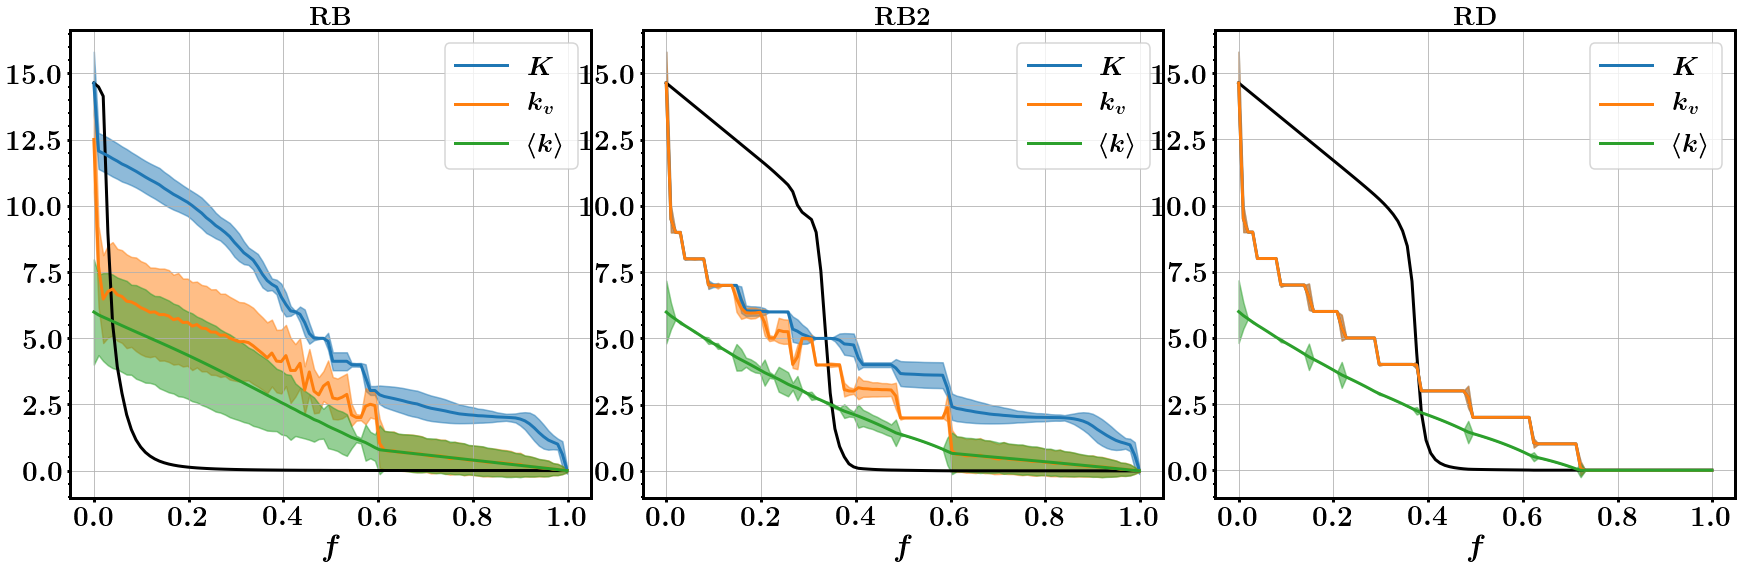

In [50]:
ncols = len(attacks)
nrows = 1
fig, axes = plt.subplots(figsize=(8*ncols, 8*nrows), ncols=ncols, nrows=nrows)

for i, attack in enumerate(attacks):
    dfs = dfs_dict[attack]
    
    df = pd.concat(dfs)
    df_std = df.groupby(by='f').std()
    df = df.groupby(by='f').mean()

    X = df.index

    ax = axes[i]
    ax.set_title(attack_dict[attack], fontsize=26)
    ax.grid(True)
    ax.set_xlabel(r'$f$')
    #ax.set_yticks(range(13))
    ax.plot(X, df.Ngcc*df.kmax[0]/N, color='k')
    
    ax.plot(X, df.kmax, label=r'$K$')
    y1 = df.kmax - df_std.kmax
    y2 = df.kmax + df_std.kmax
    ax.fill_between(X, y1, y2, color='C0', alpha=0.5)

    ax.plot(X, df.kv, label=r'$k_v$')
    y1 = df.kv - df_std.kv
    y2 = df.kv + df_std.kv
    ax.fill_between(X, y1, y2, color='C1', alpha=0.5)

    ax.plot(X, df.meank, label=r'$\langle k\rangle$')
    y1 = df.meank - df_std.kv
    y2 = df.meank + df_std.kv
    ax.fill_between(X, y1, y2, color='C2', alpha=0.5)    

    ax.legend()

plt.tight_layout()
plt.show()

In [57]:
import pickle
pickle.dump(dfs_dict, open('../temp/dfs_dict.pickle', 'wb'))